In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

from sqlalchemy import create_engine
engine = create_engine('postgresql://user:@localhost:5432/postgres')
conn = engine.connect() 

from geoalchemy2 import Geometry, WKTElement


%matplotlib inline


Helper functions

In [3]:
def stdarize(X):
    std = np.std(X)
    mean = np.mean(X)
    
    return((X-X.mean())/X.std())

In [4]:
def round_ceil_decade(x):
    return(int(np.ceil(x/10)*10))

In [5]:
palette = {"A":"#5FCE72","B":"#0BC0ED","C":"#FFD419","D":"#FF4B19"}
D_highlight_palette = {"A":"#b2b2b2","B":"#b2b2b2","C":"#b2b2b2","D":"#FF4B19"}
D_highlight_palette2 = {"not_D":"#6b6b6b","D":"#FF4B19"}


# Purpose
- Explore renewal boundaries and public housing data
- Also explore HISDAC: see whether the BUI lines up with UR boundaries? 


# 0. Prep Data
## 0.1 Load the tract data join to HOLC areas

In [6]:
sql = f'''
    select * from "tracts_holc_final_jun4"
    '''
tracts_holc = gpd.read_postgis(sql,con=conn,geom_col='geometry')

tracts_holc = tracts_holc.sort_values(['gisjoin','year']).reset_index()
tracts_holc = tracts_holc.rename(columns={'1910_earlier_perc':'teens_earlier_perc',
                                                    '1940_later_perc':'forties_later_perc'}) ##Note: mis-coded the data and 1910 should be 1919

CPI from https://www.census.gov/topics/income-poverty/income/guidance/current-vs-constant-dollars.html

In [7]:
cpi = pd.read_csv('CPI_U_RS.csv')

## 0.2  Census Tract data

In [8]:
years = [1940,1950,1960,1970,1980,1990,2000,2010]

census_all = []
for y in years: 
    sql = '''
        select * from "census_1940_overlay_{}_new"
        '''.format(y)
    df =  gpd.read_postgis(sql,con=conn,geom_col='geom')
    df['year'] = y
    infl = cpi[cpi['Year']==2010]['CPI'].values[0]/cpi[cpi['Year']==y]['CPI'].values[0]
    print(infl)
    if y>=1950:
        
        df['median_income_adj'] = df['median_income']*infl
    df['median_homevalue_adj'] = df['median_homevalue']*infl
    census_all.append(df)

14.11453744493392
7.9111111111111105
6.4466800804828965
5.014084507042253
2.5208497246262787
1.6189994946942898
1.2669039145907472
1.0


In [9]:
census_tracts = pd.concat(census_all)
census_tracts =census_tracts.to_crs(epsg=4326)

In [11]:
census_tracts.groupby('year').describe()[['median_income','median_income_adj']]

median_income                                                 \
             count          mean           std  min           25%   
year                                                                
1940           0.0           NaN           NaN  NaN           NaN   
1950        6994.0   2883.270638   1335.376649  0.0   2286.250000   
1960        7413.0   6130.075155   2119.993257  0.0   4942.500000   
1970        7540.0   9348.289543   3520.609981  0.0   7221.375000   
1980        7539.0  13882.419176   6434.653739  0.0   9457.500000   
1990        7539.0  24624.460660  13351.988804  0.0  15568.000000   
2000        7543.0  34575.592540  18502.469594  0.0  22336.540342   
2010        7546.0  43418.251760  24729.088116  0.0  26137.103306   

                                                median_income_adj  \
               50%           75%            max             count   
year                                                                
1940           NaN           NaN            NaN               0.0   
1950   3122.000000   3667.399482   15731.009601            6994.0   
1960   5974.000000   6998.237455   30755.000000            7413.0   
1970   9065.000000  10928.250000   50493.248004            7540.0   
1980  13209.000000  17122.127052   75000.000000            7539.0   
1990  22647.103269  31266.668667  150001.000000            7539.0   
2000  31000.000000  42062.890665  200001.000000            7543.0   
2010  37690.157105  54224.500000  249194.000000            7546.0   

                                                                   \
              mean           std  min           25%           50%   
year                                                                
1940           NaN           NaN  NaN           NaN           NaN   
1950  22809.874377  10564.313044  0.0  18086.777778  24698.488889   
1960  39518.633395  13666.918302  0.0  31862.716298  38512.466801   
1970  46873.113766  17652.635959  0.0  36208.584507  45452.676056   
1980  34995.492557  16220.795105  0.0  23840.936271  33297.904013   
1990  39866.989366  21616.863128  0.0  25204.584133  36665.648749   
2000  43803.953539  23440.851159  0.0  28298.250398  39274.021352   
2010  43418.251760  24729.088116  0.0  26137.103306  37690.157105   

                                   
               75%            max  
year                               
1940           NaN            NaN  
1950  29013.204788  124449.764845  
1960  45115.398000  198267.645875  
1970  54795.169014  253177.412528  
1980  43162.309265  189063.729347  
1990  50620.720772  242851.543204  
2000  53289.640842  253382.049822  
2010  54224.500000  249194.000000

In [441]:
census_tracts.groupby('year').mean()['median_income_adj']

year
1940             NaN
1950    29075.852588
1960    39518.633395
1970    46873.113766
1980    34995.492557
1990    39866.989366
2000    43803.953539
2010    43418.251760
Name: median_income_adj, dtype: float64

Rename columns

In [442]:
census_tracts = census_tracts.rename(columns={'colored':'black',
                                             'colored_perc':'black_perc'})

Extract state and county

In [443]:
census_tracts['state'] = census_tracts['gisjoin'].apply(lambda x: x[1:3])
census_tracts['county'] = census_tracts['gisjoin'].apply(lambda x: x[4:7])

Pivot tracts so decade is separate column

In [444]:
census_tracts1 = census_tracts.pivot(index=['gisjoin_1940','gisjoin','state','county'], 
                                     columns='year', values=['geom','population',
       'white', 'white_perc', 'black', 'black_perc', 'other', 'other_perc',
       'median_homevalue', 'median_homevalue_adj', 'homes', 'college',
       'college_perc', 'owned_perc', 'population_density', 'year',
       'median_income_adj', 'median_income', 'hispanic_perc', 'hispanic',
       'asian_perc', 'asian', 'unemployed', 'unemployed_perc','Total_units', '1940_later', '1930_1939', '1920_1929',
 '1910_earlier','1940_later_perc', '1930_1939_perc', '1920_1929_perc', '1910_earlier_perc'])

census_tracts1.columns = [col[0]+'_'+str(col[1]) for col in census_tracts1.columns.values]
census_tracts1 = census_tracts1.reset_index()\
                                .drop(columns=['geom_1950','geom_1960','geom_1970','geom_1980','geom_1990','geom_2000','geom_2010']).rename(columns={'geom_1940':'geom'})

census_tracts1 = gpd.GeoDataFrame(census_tracts1,geometry='geom')
census_tracts1 = census_tracts1.set_crs('epsg:4326')

In [445]:
census_tracts1 = census_tracts1.dropna(axis=1,how='all')

## 0.3 Get NYC data

### 0.3.1
Uses the 1930 boundaries, which are smaller than the 1940 boundaries, and similar to 1950 boundaries.

In [446]:
# sql = f'''
#     select * from "census_1930" where "STATEA" = 36 
#     '''
# census_1930_nyc =  pd.read_sql(sql,con=conn)
# census_1930_nyc = census_1930_nyc[census_1930_nyc.COUNTYA.isin([ 5,  47,  61,  81,  85,])].rename(
#                                     columns={'colored':'black',
#                                              'colored_perc':'black_perc'})


sql = f'''
    select * from "us_tract_1930_conflated_4326" where "state" = '36'
    '''
tract_1930_nyc_boundaries =  gpd.read_postgis(sql,con=conn,geom_col='geom')
tract_1930_nyc_boundaries = tract_1930_nyc_boundaries[tract_1930_nyc_boundaries['county'].isin(['005','047','061','081','085'])]
# census_1930_nyc1 = census_1930_nyc_boundaries.merge(census_1930_nyc,right_on='GISJOIN',left_on='gisjoin')

In [447]:
tract_1930_nyc_boundaries.shape

(3413, 18)

Get area in meters

In [448]:
tract_1930_nyc_boundaries['area'] = tract_1930_nyc_boundaries.to_crs(3857).area

Get the census tract data for NYC 1930, 1940, and 1950. 

In [449]:
### This first table has the Census data but no state or country IDs to filter for just NYC
years = [1940,1950,1960,1970,1980,1990,2000,2010]

census_all_nyc = []
for y in years: 

    
    sql = '''
        select * from "census_1930_overlay_{}" 
        '''.format(y)
    df_nyc =  gpd.read_postgis(sql,con=conn,geom_col='geom')
    df_nyc = df_nyc[df_nyc['gisjoin'].isin(tract_1930_nyc_boundaries['gisjoin'].values)]
    df_nyc.gisjoin_1930= df_nyc.gisjoin_1930.astype(str)
    df_nyc['area'] = df_nyc.to_crs(3857).area
    
    df_nyc['year'] = y
    infl = cpi[cpi['Year']==2010]['CPI'].values[0]/cpi[cpi['Year']==y]['CPI'].values[0]
    print(infl)
    if y>1950:
        
        df_nyc['median_income_adj'] = df_nyc['median_income']*infl
    df_nyc['median_homevalue_adj'] = df_nyc['median_homevalue']*infl
    census_all_nyc.append(df_nyc)

14.11453744493392
7.9111111111111105
6.4466800804828965
5.014084507042253
2.5208497246262787
1.6189994946942898
1.2669039145907472
1.0


In [450]:
census_all_nyc = pd.concat(census_all_nyc)
census_all_nyc =census_all_nyc.to_crs(epsg=4326)

Pivot columns

In [451]:
cols_1940 = ['population',
       'white', 'white_perc', 'colored', 'colored_perc', 'other', 'other_perc',
       'median_homevalue', 'median_homevalue_adj', 'homes', 'college',
       'college_perc','owned_perc',
       'population_density']
cols = ['population',
       'white', 'white_perc', 'colored', 'colored_perc', 'other', 'other_perc','median_income','median_income_adj',
       'median_homevalue', 'median_homevalue_adj', 'homes', 'college',
       'college_perc','owned_perc',
       'population_density']
cols_1950 = cols+['Total_units', '1940_later', '1930_1939',
       '1920_1929', '1910_earlier', '1940_later_perc', '1930_1939_perc',
       '1920_1929_perc', '1910_earlier_perc']
renamed_1940_cols = dict(zip(cols_1940,[x+"_1940" for x in cols_1940]))
renamed_1950_cols = dict(zip(cols_1950,[x+"_1950" for x in cols_1950]))
renamed_1960_cols = dict(zip(cols,[x+"_1960" for x in cols]))
renamed_1970_cols = dict(zip(cols,[x+"_1970" for x in cols]))
renamed_1980_cols = dict(zip(cols,[x+"_1980" for x in cols]))
renamed_1990_cols = dict(zip(cols,[x+"_1990" for x in cols]))
renamed_2000_cols = dict(zip(cols,[x+"_2000" for x in cols]))
renamed_2010_cols = dict(zip(cols,[x+"_2010" for x in cols]))


In [461]:
census_1940_nyc_USE = census_all_nyc[census_all_nyc['year']==1940].rename(columns=renamed_1940_cols).merge(census_all_nyc[census_all_nyc['year']==1950][['gisjoin_1930']+cols_1950].rename(columns=renamed_1950_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==1960][['gisjoin_1930']+cols].rename(columns=renamed_1960_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==1970][['gisjoin_1930']+cols].rename(columns=renamed_1970_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==1980][['gisjoin_1930']+cols].rename(columns=renamed_1980_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==1990][['gisjoin_1930']+cols].rename(columns=renamed_1990_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==2000][['gisjoin_1930']+cols].rename(columns=renamed_2000_cols),on='gisjoin_1930')
census_1940_nyc_USE = census_1940_nyc_USE.merge(census_all_nyc[census_all_nyc['year']==2010][['gisjoin_1930']+cols].rename(columns=renamed_2010_cols),on='gisjoin_1930')

# ## There is one tract with no data?
census_1940_nyc_USE = census_1940_nyc_USE[census_1940_nyc_USE['gisjoin']!='G3600810nodata']

In [618]:
f = lambda x: x if 'colored' not in str(x) else x.replace('colored','black') 
census_1940_nyc_USE.columns = list(map(f,census_1940_nyc_USE))

Check that filter worked

<AxesSubplot:>

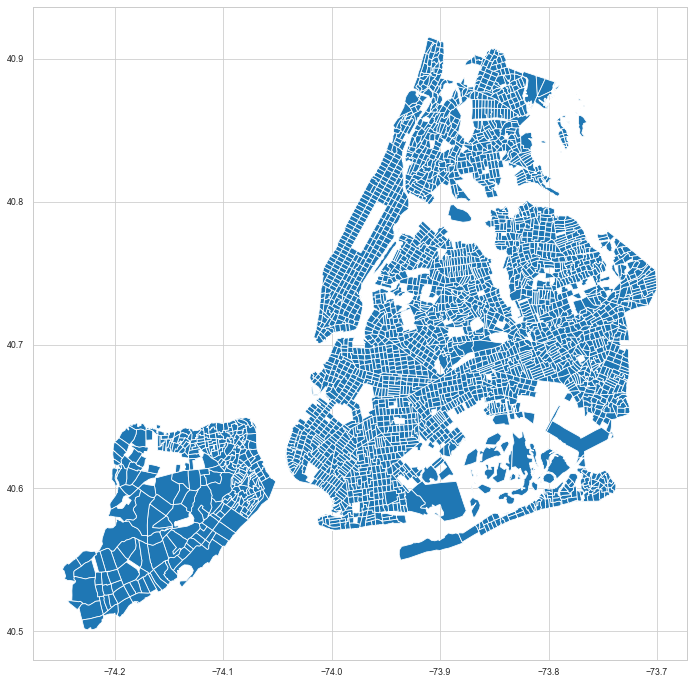

In [462]:
census_1940_nyc_USE.geom.plot(figsize=(12,12))

## 0.4 Data on Urban Renewal Areas
- For now, using these categories:
    - 'urban renewal grants approved/reserved'
    - 'project status'
    - 'white families', 'non-white families','total families'
    - 'proposed reuse of project land- total',
    

### 0.4.1 Get the UR boundaries that we currently have

In [36]:
ur_boundaries = gpd.read_file('../data/DSL/UR_Projects_wenfeiedits/ur_projects_wxedits.shp')
# Format names for consistency
ur_boundaries['city'] = ur_boundaries['city'].replace(['nyc'],value='New York')
ur_boundaries['city'] = ur_boundaries['city'].str.replace('_',' ')
ur_boundaries['city'] = ur_boundaries['city'].str.title()

ur_boundaries['city'] = ur_boundaries['city'].replace(['Nyc'],'New York')
ur_boundaries['city'] = ur_boundaries['city'].replace(['Philadelphia\r\n'],'Philadelphia')

ur_boundaries['project'] = ur_boundaries['project'].str.title()

## Remove duplicate geometries
ur_boundaries = ur_boundaries.groupby('project_id').first().reset_index()
ur_boundaries = ur_boundaries.set_crs(epsg=4326)

## Format names for consistency
ur_boundaries['state'] = ur_boundaries['state'].str.upper()


### 0.4.2 Get the UR Projects Data

In [37]:
ur_data = pd.read_csv('../data/DSL/UR_Projects/non_spatial_data.csv')

## Format names for consistency
ur_data['city'] = ur_data['city'].replace(['nyc'],value='New York')
ur_data['city'] = ur_data['city'].str.title()

ur_data['state'] = ur_data['state'].str.upper()

ur_data['project'] = ur_data['project'].str.title()

Create a table of the latest amt approved and dispursed for each UR project

In [38]:
ur_project_res_first = ur_data[(ur_data.cat== 'urban renewal grants approved/reserved')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .first()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_reserved_first',
                                                                'year':'amt_reserved_year_first'})

ur_project_res_first1 = ur_project_res_first[ur_project_res_first.amt_reserved_first.isna()==False]

## Now create a column indicated when is the first census year these effects would show in the data
ur_project_res_first1['census_year_first'] = ur_project_res_first1['amt_reserved_year_first'].apply(round_ceil_decade)

<ipython-input-38-90853e73a8ce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ur_project_res_first1['census_year_first'] = ur_project_res_first1['amt_reserved_year_first'].apply(round_ceil_decade)


In [39]:
ur_project_res_last = ur_data[(ur_data.cat== 'urban renewal grants approved/reserved')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_reserved_last',
                                                                'year':'amt_reserved_year_last'})

ur_project_res_last1 = ur_project_res_last[ur_project_res_last.amt_reserved_last.isna()==False]


In [40]:
ur_project_dis_first = ur_data[(ur_data.cat== 'urban renewal grants dispursed')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .first()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_dispursed_first',
                                                                'year':'amt_dispursed_year_first'})

ur_project_dis_first1 = ur_project_dis_first[ur_project_dis_first.amt_dispursed_first.isna()==False]


In [41]:
ur_project_dis_last = ur_data[(ur_data.cat== 'urban renewal grants dispursed')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_dispursed_last',
                                                                'year':'amt_dispursed_year_last'})

ur_project_dis_last1 = ur_project_dis_last[ur_project_dis_last.amt_dispursed_last.isna()==False]

Create a table of the latest status for each UR project

In [42]:
ur_project_status = ur_data[ur_data.cat== 'project status']\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index()\
                                .rename(columns={'value':'project_status',
                                                'year':'project_status_year'})

Join to project boundaries

In [43]:
ur = ur_boundaries.drop(columns=['city','state'])\
                    .merge(ur_project_res_first1[['project_id','amt_reserved_first','amt_reserved_year_first','census_year_first','project','city','state']],
                        on=['project_id'],
                        how='right')\
                  .rename(columns={'project_y':'project'})\
                  .merge(ur_project_res_last1[['project_id','amt_reserved_last','amt_reserved_year_last']],
                        on=['project_id'],
                        how='right')\
                  .rename(columns={'project_y':'project'})
ur = ur.drop(columns=['project_x'])

In [44]:
print(ur_boundaries.shape,ur.shape)

(740, 11) (3941, 16)


####  Note

The main projects that are missing from the NYC urban renewal projects, which had any amount of money disbursed are other programs that fall within the umbrella of UR. 

Here is what each of these programs did: 
- **[Community Renewal Program](https://planning-org-uploaded-media.s3.amazonaws.com/document/PAS-Report-157.pdf)**: 
    - **1959 Housing Act change in UR legislation**. "Enough experience had been gained to realize the shortcomings of the traditional project-by-project approach to urban renewal...Consequently, the idea of establishing a vehicle for a city-wide approach to renewal gained momentum among the leaders of the urban renewal movement." *Recognized need for a broader policy framework*
    - "**A brief statement of what a CRP could include**: identification of blighted areas in the connnunity; measurement of blight within such areas; determination of resources needed and available to.renew such areas; identification of potential project areas and contemplated renewal actions within such areas; and programing of renewal activities."
    - "**A CRP is intended to be fully comprehensive in coverage.** Its focus is the total community, the analyses called for incorporating that area and, in some instances, the whole metropolitan area."
    - From *[New York City's renewal strategy, 1965](https://babel.hathitrust.org/cgi/pt?id=nnc2.ark:/13960/t7qn8qf9p&view=1up&seq=15&skin=2021&q1=%22community%20renewal%22)*: The scope of the Program's work has shifted to the entire city.""
    - Summary of plans: 
        1) Gradual reconstruction (1800 blocks)
        2) Immediate improvement actions: housing code enforcement, housing improvement, and continous maintenance
    - Important to *preserve* existing housing stock
- **[Neighborhood Development Program](https://www.hud.gov/sites/documents/DOC_16470.PDF)**: Precursor to Community Development Block Grantn (CDBG)
    - **Housing Act of 1968** to facilitate ore rapid rehabilitation and redevelopment of blighted areas. From [here](https://www.google.com/books/edition/Urban_Renewal_Directory/Q6oqAAAAMAAJ?hl=en&gbpv=1&dq=%22museum+of+natural+history%22+nyc+%22urban+renewal%22&pg=RA6-PA63-IA6&printsec=frontcover).
    - From [here](https://www.jstor.org/stable/pdf/27892636.pdf?refreqid=excelsior%3Ab4390a21f68b8fcacf0869153eea5e97):"A new aproach to urban renewal was decided upon, to be known as the Neighborhood Development Program, which would enable communities to accomplish meaningful activities quickly and on a more flexible basis, while at the same time achieving a better ratio between dollars committed and dollars spent and, therefore, actual achieve ments. This new approach to urban renewal, based on funding annual programs, was deemed especially appropriate as a companion to the model cities program, which was also based on the carrying out of annual action programs"
    - From **[Block Grants for Community Development](https://www.huduser.gov/Publications/pdf/HUD-000048.pdf)**: "The last listed, the neighborhood development program, was, in effect, a special sub-program of urban renewal involving annualized grants"
    - 2.189bn dollars distributed vs 9.5bn of UR
    - Established in 1968, **change the funding structure of reserve system [of UR] to annual funding**
    - "Our analysls lndicates that big cities (above 500,000) with high urban renewal grants tended to maintain their funding levels after NDP was established" (169)
       - *These were often projects that were transferred from UR projects*, so presumably same footprint.
- **Demonstation Project**: 
    - **Housing Act of 1954** created programs to improve urban renewal techniques. 
- **Code Enforcement Project**
    - **Housing Act of 1965** help arrest decline of deteriorating areas by concentrating on code enforcement
- **Demolition Project**
    - **Housing Act of 1965** demolition of unsafe structures.
    

### 0.4.2.2 Data Cleaning

Broadly, here are the types of projects that should be removed from the data: 
- Later programs that updated UR (to contain less slum clearance/demolition): 
    - Community Renewal
    - Neighborhood Development
    - Code Enforcement
    - **Actually**, going to remove Demolition Project,Interim Asst Prog,Demonstation Projec 
- Outliers: 
    - City is "Connecticut State At Large"

In [45]:
ur1 = ur[(ur['project'].str.contains('Community Renewal|Neighborhood Dev|Code')==False)&\
         (ur['city']!='Connecticut State At Large')]

#### 0.4.2.3 How many of the projects are missing in each city? 

In [2]:
ur1['has_geom'] = ur1.apply(lambda x: 0 if np.isnan(x['Shape_Area'])  else 1, axis=1)

In [47]:
ur_hasgeom_bycity_num = ur1.groupby(['state','city'])\
                        .sum()[['has_geom']]\
                        .rename(columns={'project_id':'num_notmissing'})
ur_hasgeom_bycity_total = ur1.groupby(['state','city'])\
                        .count()[['project_id']]\
                        .rename(columns={'project_id':'total'})

ur_hasgeom_bycity_perc = (ur1.groupby(['state','city'])\
                              .sum()[['has_geom']]\
                              .rename(columns={'has_geom':'num_notmissing'})/ur1.groupby(['state','city'])\
                                                 .count()[['has_geom']]\
                                                 .rename(columns={'has_geom':'num_notmissing'})).rename(columns={'num_notmissing':'perc_notmissing'})

ur_hasgeom_bycity = pd.concat([ur_hasgeom_bycity_num,ur_hasgeom_bycity_perc,ur_hasgeom_bycity_total],axis=1).reset_index()
ur_hasgeom_bycity = ur_hasgeom_bycity.sort_values(['perc_notmissing','total'],ascending=False)

## 0.5 Public Housing data

In [48]:
public_housing1 = gpd.read_file('../data/PublicHousing/Public_Housing_Buildings-shp/Public_Housing_Buildings.shp')


In [49]:
public_housing = gpd.GeoDataFrame(public_housing1[['OBJECTID', 'PARTICIPAN', 'FORMAL_PAR', 'DEVELOPMEN', 'PROJECT_NA',
       'BUILDING_N', 'BUILDING_1', 'BUILDING_T', 'BUILDING_S', 'NATIONAL_B',
       'CONSTRUCT_', 'DOFA_ACTUA', 'TOTAL_DWEL', 'ACC_UNITS', 'TOTAL_OCCU','STD_CITY','STD_ST','RAD_TYPE','PHA_TOTAL_','METRO','geometry']])

In [50]:
public_housing['year']= public_housing['CONSTRUCT_'].apply(lambda x: int(x[:4]))
public_housing['CONSTRUCT_']= pd.to_datetime(public_housing['CONSTRUCT_'])
public_housing['occupancy_year']= public_housing['DOFA_ACTUA'].apply(lambda x: int(x[:4]))
public_housing['occupancy_date']= pd.to_datetime(public_housing['DOFA_ACTUA'])


In [51]:
public_housing.shape

(204577, 24)

In [52]:
public_housing_agg = public_housing.groupby('DEVELOPMEN').agg({'TOTAL_DWEL':'sum', 'year':'mean','OBJECTID':'first', 'PARTICIPAN':'first', 
                                                  'FORMAL_PAR':'first', 'PROJECT_NA':'first','STD_CITY':'first',
                                                  'STD_ST':'first','RAD_TYPE':'first','PHA_TOTAL_':'first','OBJECTID':'count'}).reset_index()

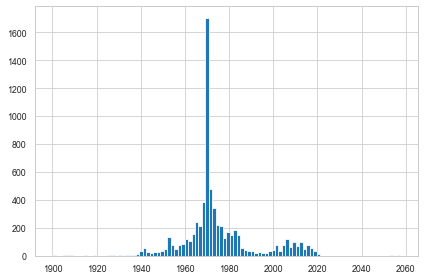

In [53]:
public_housing_agg['year'].hist(bins=100)
plt.tight_layout()
plt.savefig('Results/housing_developments_byyear.png')

## 0.6 City center information

In [54]:
city_centers = gpd.read_file('../data/city_centers/citiesx010g.shp')
city_centers = city_centers.sort_values(['STATE_FIPS','COUNTYFIPS','POP_2010'],ascending=False)\
                            .groupby(['STATE_FIPS','COUNTYFIPS'])\
                            .first()\
                            .reset_index()

# 1. Join 1940s tracts to UR in NYC

In [619]:
ur_overlay = gpd.overlay(census_1940_nyc_USE,
                         ur1.to_crs(4326))
ur_overlay['area'] = ur_overlay.to_crs(3857).area

ur_boundaries['area_ur_total'] = ur_boundaries.to_crs(3857).area

Find % overlay to total UR area

In [620]:
ur_overlay1 = pd.merge(ur_boundaries,ur_overlay[['gisjoin','city_id','project_id','project','area','census_year_first']],on=['city_id','project_id','project'])
ur_overlay1['ur_overlay_percentage'] = ur_overlay1['area']/ur_overlay1['area_ur_total']
ur_overlay2 = ur_overlay1[ur_overlay1.ur_overlay_percentage>.1]

<AxesSubplot:>

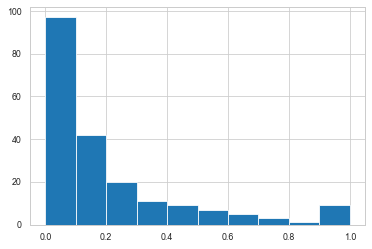

In [769]:
ur_overlay1['ur_overlay_percentage'].hist()

Aggregate to the tract 

In [621]:
ur_overlay3 = ur_overlay2.groupby(['gisjoin','census_year_first'])\
                        .agg(['sum','count'])[['ur_overlay_percentage','area']]\
                        .reset_index()

ur_overlay3 = pd.concat([ur_overlay3['ur_overlay_percentage'].rename(columns={'sum':'ur_overlay_percentage_projects_in_tract',
                                                                             'count':'total_ur_projects_projects_in_tract'}),
                         ur_overlay3['area']['sum'],
                         ur_overlay3['gisjoin'],
                         ur_overlay3['census_year_first']],axis=1).rename(columns={'sum':'ur_area_total'})



Join back to NYC census tract

In [622]:
census_1940_nyc_USE_1 = census_1940_nyc_USE.merge(ur_overlay3,on='gisjoin',how='left')

## Fill na
census_1940_nyc_USE_1['ur_overlay_percentage_projects_in_tract'] = census_1940_nyc_USE_1['ur_overlay_percentage_projects_in_tract'].fillna(0)
census_1940_nyc_USE_1['total_ur_projects_projects_in_tract'] = census_1940_nyc_USE_1['total_ur_projects_projects_in_tract'].fillna(0)
census_1940_nyc_USE_1['ur_area_total'] = census_1940_nyc_USE_1['ur_area_total'].fillna(0)

## Get the total percentage of land cover for the project
census_1940_nyc_USE_1['total_projects_perc_of_tract'] = census_1940_nyc_USE_1['ur_area_total']/census_1940_nyc_USE_1['area']


Designate a certain % coverage as "UR tract", optionalyl create two periods for this split.

In [623]:
census_1940_nyc_USE_1['has_ur'] = census_1940_nyc_USE_1.apply(lambda x: 'yes' if (x['total_projects_perc_of_tract']>.1) else 'no',axis=1)
census_1940_nyc_USE_1['has_ur_1960'] = census_1940_nyc_USE_1.apply(lambda x: 'yes' if (x['total_projects_perc_of_tract']>.1 and x['census_year_first']==1960) else 'no',axis=1)
census_1940_nyc_USE_1['has_ur_1970'] = census_1940_nyc_USE_1.apply(lambda x: 'yes' if (x['total_projects_perc_of_tract']>.1 and x['census_year_first']==1970) else 'no',axis=1)


Drop any NaN or inf rows

In [624]:
df_nyc_use = census_1940_nyc_USE_1.copy()
df_nyc_use.replace([np.inf, -np.inf], np.nan, inplace=True)
df_nyc_use.dropna(how='all')

,gisjoin,geom,index,gisjoin_1930,count,population_1940,white_1940,white_perc_1940,black_1940,black_perc_1940,...,owned_perc_2010,population_density_2010,ur_overlay_percentage_projects_in_tract,total_ur_projects_projects_in_tract,ur_area_total,census_year_first,total_projects_perc_of_tract,has_ur,has_ur_1960,has_ur_1970
0,G36006100139,"MULTIPOLYGON (((-73.98238 40.76740, -73.98288 ...",3715.0,G36006100139,1,15841.0,15165.0,0.957326,584.0,0.036866,...,0.192523,0.029210,0.0,0.0,0.0,NaN,0.0,no,no,no
1,G36000500341,"MULTIPOLYGON (((-73.90070 40.91238, -73.90078 ...",2438.0,G36000500341,1,8953.0,8593.0,0.959790,324.0,0.036189,...,0.498522,0.009752,0.0,0.0,0.0,NaN,0.0,no,no,no
2,G36000500342,"MULTIPOLYGON (((-73.85867 40.86550, -73.85961 ...",2439.0,G36000500342,1,12011.0,11974.0,0.996919,36.0,0.002997,...,0.290625,0.006102,0.0,0.0,0.0,NaN,0.0,no,no,no
3,G36000500343,"MULTIPOLYGON (((-73.89663 40.91132, -73.89661 ...",2440.0,G36000500343,1,8953.0,8593.0,0.959790,324.0,0.036189,...,0.330218,0.007634,0.0,0.0,0.0,NaN,0.0,no,no,no
4,G36000500344,"MULTIPOLYGON (((-73.85578 40.86544, -73.85679 ...",2441.0,G36000500344,1,12011.0,11974.0,0.996919,36.0,0.002997,...,0.451713,0.006317,0.0,0.0,0.0,NaN,0.0,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,G36008500361,"MULTIPOLYGON (((-74.19334 40.61664, -74.19250 ...",5432.0,G36008500361,1,10710.0,10576.0,0.987488,128.0,0.011951,...,0.757905,0.001560,0.0,0.0,0.0,NaN,0.0,no,no,no
2998,G36008500363,"MULTIPOLYGON (((-74.17562 40.61222, -74.17697 ...",5433.0,G36008500363,1,10710.0,10576.0,0.987488,128.0,0.011951,...,0.757905,0.001792,0.0,0.0,0.0,NaN,0.0,no,no,no
2999,G36008500365,"MULTIPOLYGON (((-74.17824 40.59981, -74.17834 ...",5434.0,G36008500365,1,10710.0,10576.0,0.987488,128.0,0.011951,...,0.757905,0.002321,0.0,0.0,0.0,NaN,0.0,no,no,no
3000,G36008500367,"MULTIPOLYGON (((-74.19508 40.60071, -74.19493 ...",5435.0,G36008500367,1,10710.0,10576.0,0.987488,128.0,0.011951,...,0.757905,0.001638,0.0,0.0,0.0,NaN,0.0,no,no,no


Need to add in `state` and `county` columns to do the by-city standardization later

In [625]:
df_nyc_use['state']='36'
## Set all the boroughs to one county for easier calcs later
df_nyc_use['county']='005'

In [626]:
## SCRATCH

# df_use.to_pickle('nycdata.pickle')
# df_natl_use.to_pickle('natldata.pickle')

# df_use.to_file('nycdata.geojson',driver='GeoJSON')
# df_natl_use.to_file('natldata.geojson',driver='GeoJSON')


# 2. Join all UR projects to Tracts in All Cities

In [627]:
## Overlay tracts with the df of all projects (with and without geoms) to create tract pieces
ur_overlay_natl = gpd.overlay(census_tracts1,
                                 ur_boundaries.to_crs(4326),how='intersection')
ur_overlay_natl['area'] = ur_overlay_natl.to_crs(3857).area
ur_boundaries['area_ur_total'] = ur_boundaries.to_crs(3857).area

Find % overlay to total UR area

In [628]:
## SCRATCH

# census_tracts1[['geom']].to_file('scratch/census_tracts1.geojson',driver='GeoJSON')
# ur_overlay_natl[['geometry']].to_file('scratch/ur_overlay_natl.geojson',driver='GeoJSON')
# ur_overlay_natl1[['geometry']].to_file('scratch/ur_overlay_natl1.geojson',driver='GeoJSON')
# ur_overlay_natl2[['geometry']].to_file('scratch/ur_overlay_natl2.geojson',driver='GeoJSON')

In [629]:
ur_overlay_natl1 = pd.merge(ur_overlay_natl[['gisjoin','city_id','project_id','project','area','geometry']],ur_boundaries[['city_id','project_id','project','area_ur_total']],on=['city_id','project_id','project'])
ur_overlay_natl1['ur_overlay_percentage'] = ur_overlay_natl1['area']/ur_overlay_natl['area_ur_total']
ur_overlay_natl2 = ur_overlay_natl1[ur_overlay_natl1.ur_overlay_percentage>.0001]

Aggregate to the tract 

In [630]:
ur_overlay_natl3 = ur_overlay_natl2.groupby(['gisjoin'])\
                        .agg(['sum','count'])[['ur_overlay_percentage','area']]\
                        .reset_index()

ur_overlay_natl3 = pd.concat([ur_overlay_natl3['ur_overlay_percentage'].rename(columns={'sum':'ur_overlay_percentage_projects_in_tract',
                                                                             'count':'total_ur_projects_projects_in_tract'}),
                         ur_overlay_natl3['area']['sum'],
                         ur_overlay_natl3['gisjoin']],axis=1).rename(columns={'sum':'ur_area_total'})



Join back to census tract

In [631]:
census_1940_USE_1 = census_tracts1.merge(ur_overlay_natl3,on='gisjoin',how='left')
census_1940_USE_1['area'] = census_1940_USE_1.to_crs(3857).area
## Fill na
census_1940_USE_1['ur_overlay_percentage_projects_in_tract'] = census_1940_USE_1['ur_overlay_percentage_projects_in_tract'].fillna(0)
census_1940_USE_1['total_ur_projects_projects_in_tract'] = census_1940_USE_1['total_ur_projects_projects_in_tract'].fillna(0)
census_1940_USE_1['ur_area_total'] = census_1940_USE_1['ur_area_total'].fillna(0)

## Get the total percentage of land cover for the project
census_1940_USE_1['total_projects_perc_of_tract'] = census_1940_USE_1['ur_area_total']/census_1940_USE_1['area']

Designate a certain % coverage as "UR tract"

In [632]:
census_1940_USE_1['has_ur'] = census_1940_USE_1.apply(lambda x: 'yes' if (x['total_projects_perc_of_tract']>.1) else 'no',axis=1)


Remove the NYC tracts

In [633]:
census_1940_USE_2 = census_1940_USE_1[(census_1940_USE_1['state']!='36')&\
                                          (census_1940_USE_1['county'].isin(['005','047','061','081','085'])==False)]



Drop any NaN or inf rows

In [634]:
df_natl_use = census_1940_USE_2.copy()
df_natl_use.replace([np.inf, -np.inf], np.nan, inplace=True)
df_natl_use = df_natl_use.dropna(how='all')

Rename cols

In [648]:
df_natl_use.columns =  list(map(f,df_natl_use))


In [636]:
df_natl_use.mean()[['median_income_adj_1950','median_income_adj_1960','median_income_adj_1970','median_income_adj_1980',
                   'median_homevalue_adj_1950','median_homevalue_adj_1960','median_homevalue_adj_1970','median_homevalue_adj_1980']]

median_income_adj_1950        29104.485949
median_income_adj_1960        39457.653508
median_income_adj_1970        46782.739162
median_income_adj_1980        35170.000525
median_homevalue_adj_1950     55987.642637
median_homevalue_adj_1960     76183.902338
median_homevalue_adj_1970     82055.843430
median_homevalue_adj_1980    109340.217645
dtype: float64

In [ ]:
df_nyc_use.to_file('Final/Data/df_nyc_use.gpkg',driver='GPKG')
df_natl_use.to_file('Final/Data/df_natl_use.gpkg',driver='GPKG')

Create a df from NYC and non-NYC data

In [ ]:
df_nyc_use['nyc'] = 'yes'
df_natl_use['nyc'] = 'no'
df_all_use = pd.concat([df_nyc_use,df_natl_use[df_natl_use.columns[df_natl_use.columns.isin(df_nyc_use.columns)]]]).reset_index()
df_all_use = df_all_use[~df_all_use.geometry.isna()]

In [ ]:
df_all_use.mean()[['median_income_adj_1950','median_income_adj_1960','median_income_adj_1970','median_income_adj_1980',
                   'median_homevalue_adj_1950','median_homevalue_adj_1960','median_homevalue_adj_1970','median_homevalue_adj_1980']]

/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/851552042.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_all_use.mean()[['median_income_adj_1950','median_income_adj_1960','median_income_adj_1970','median_income_adj_1980',


median_income_adj_1950        23513.587917
median_income_adj_1960        40899.169621
median_income_adj_1970        49034.594142
median_income_adj_1980        36675.879002
median_homevalue_adj_1950     50330.333464
median_homevalue_adj_1960     86157.778082
median_homevalue_adj_1970     91147.590335
median_homevalue_adj_1980    114089.542188
dtype: float64

## 3.1 Feature creation 

Get distance to city centers

In [ ]:
df_all_use['dist_to_center'] = df_all_use.merge(city_centers[['NAME','STATE','STATE_FIPS','COUNTYFIPS','geometry']], 
                 left_on =['state','county'],
                 right_on = ['STATE_FIPS','COUNTYFIPS'],how='left').apply(lambda x: x['geometry_x'].centroid.distance(x['geometry_y']),axis=1)

In [ ]:
df_all_use1 =pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(df_all_use,
                       df_all_use.groupby(['state','county']).sum()['population_1950']\
                                                            .rename('county_pop_1950'),
                       on=['state','county']),
                       df_all_use.groupby(['state','county']).sum()['population_1980']\
                                                            .rename('county_pop_1980'),
                       on=['state','county']),
                      df_all_use.groupby(['state','county']).sum()['population_1940']\
                                                            .rename('county_pop_1940'),
                       on=['state','county']),
                      df_all_use.groupby(['state','county']).sum()['population_1960']\
                                                            .rename('county_pop_1960'),
                        on=['state','county']),
                      df_all_use.groupby(['state','county']).sum()['population_1970']\
                                                            .rename('county_pop_1970'),
                      on=['state','county'])


/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/2660192979.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all_use.groupby(['state','county']).sum()['population_1950']\
/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/2660192979.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all_use.groupby(['state','county']).sum()['population_1980']\
/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/2660192979.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Eit

In [ ]:
df_all_use1_1 = df_all_use1.merge(city_centers[['STATE_FIPS','COUNTYFIPS','COUNTY','STATE','NAME']].rename(columns={'NAME':'city_name'}),
                            left_on=['state','county'],
                  right_on=['STATE_FIPS','COUNTYFIPS'])

Join to public housing units

In [ ]:
public_housing1 = public_housing[(public_housing.year>=1949)&(public_housing.year<=1975)]
public_housing2 = gpd.GeoDataFrame(public_housing1[['occupancy_year','OBJECTID','TOTAL_DWEL','year','CONSTRUCT_','geometry']])

In [ ]:
ph_join = gpd.sjoin(df_all_use1_1[['geometry','gisjoin']],public_housing2)

/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/80019433.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  ph_join = gpd.sjoin(df_all_use1_1[['geometry','gisjoin']],public_housing2)


In [ ]:
ph1 = ph_join.groupby(ph_join.index).count()[['OBJECTID']].rename(columns={'OBJECTID':'ph_buildings_count'})
ph2 = ph_join.groupby(ph_join.index).mean()[['year']].rename(columns={'year':'ph_mean_constr_year'})
ph3 = ph_join.groupby(ph_join.index).sum()[['TOTAL_DWEL']].rename(columns={'TOTAL_DWEL':'ph_total_units_in_tract'})
ph4 = ph_join.groupby(ph_join.index).mean()[['year']].rename(columns={'year':'ph_mean_constr_year'})


ph_use = pd.concat([ph1,ph2,ph3],axis=1)


ph_use['ph_closest_constr_decade'] = ph_use['ph_mean_constr_year'].apply(lambda x: round_ceil_decade(x) if np.isnan(x)==False else 0 )


/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/1575439221.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ph2 = ph_join.groupby(ph_join.index).mean()[['year']].rename(columns={'year':'ph_mean_constr_year'})
/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/1575439221.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ph3 = ph_join.groupby(ph_join.index).sum()[['TOTAL_DWEL']].rename(columns={'TOTAL_DWEL':'ph_total_units_in_tract'})
/var/folders/cy/x4wtz_6d12s786ynvlhf_sf00000gq/T/ipykernel_45327/1575439221.py:4: FutureWarning: The default value of numeric_only in DataFram

In [ ]:
df_all_use1_2= df_all_use1_1.merge(ph_use,left_index=True,right_index=True,how='left')
df_all_use2 = df_all_use1_2.copy()
df_all_use2['has_ph'] = df_all_use2['ph_mean_constr_year'].apply(lambda x: 0 if np.isnan(x) else 1)

In [ ]:
df_all_use2.to_file('Final/data/df_all_use2.geojson',driver='GeoJSON')